In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import f1_score
import torch
from torch.utils.data import Dataset

In [ ]:
import os
import pandas as pd

# Set the path to the directory containing the datasets
dataset_path = '/kaggle/input/fault-detection'

# Get the list of files in the directory
files = os.listdir(dataset_path)

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the files and read them into DataFrames
for file in files[:3]:  # Assuming you want to read the first 15 datasets
    file_path = os.path.join(dataset_path, file)
    df= pd.read_csv(file_path)
    # df['class'] = 'faultySignal'  # Change the file reading method based on your file format
    dfs.append(df)

# Concatenate all DataFrames into one
final_df = pd.concat(dfs, ignore_index=True)

final_df


,norm_t,mean_t,std_t,skew_t,kurt_t,max_t,norm_f,mean_f,std_f,skew_f,...,max_a5_db4,max_cd1_db4,max_cd2_db4,max_cd3_db4,max_cd4_db4,max_cd5_db4,locLabel,measloc,resistance,faultLabel
0,0.000438,-0.022042,0.019590,-0.979555,1.005862,0.010152,0.000454,0.016955,0.021353,1.036937,...,0.000105,2.274616e-08,8.531768e-07,4.657510e-07,0.000001,0.000007,1,1,0.0010,ABCG
1,0.129230,-0.326141,0.392308,-1.081040,1.010600,0.243330,0.121197,0.323990,0.348179,0.941886,...,0.059927,5.211159e-07,1.146017e-04,1.097209e-04,0.000280,0.000216,1,1,0.0273,ABCG
2,0.292590,-0.440137,0.632733,-1.060412,0.969647,0.409214,0.258202,0.512369,0.507552,0.901947,...,0.169775,1.610872e-06,3.983491e-04,3.796074e-04,0.001021,0.000791,1,1,0.0535,ABCG
3,0.001950,-3.374825,0.040920,-0.028003,0.005230,0.015670,0.002217,0.016758,0.110095,5.090591,...,0.043128,5.107586e-04,9.973887e-05,6.676336e-05,0.000894,0.001020,1,2,0.0010,ABCG
4,0.001950,-3.374825,0.040920,-0.028003,0.005230,0.015670,0.002217,0.016758,0.110095,5.090591,...,0.043128,5.107586e-04,9.973887e-05,6.676336e-05,0.000894,0.001020,1,2,0.0273,ABCG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.852278,-1.320850,0.702879,-0.598063,0.870597,1.133930,1.048940,0.485097,1.033184,1.215652,...,1.314887,7.049712e-01,7.305406e-02,1.133269e+01,1.057026,9.706355,4,3,2.0000,CG
11612,0.388596,-1.050649,0.426651,-0.231337,0.277760,0.225217,0.518506,0.177879,0.751787,1.456125,...,0.590762,1.713605e-07,2.735332e-05,1.153053e-04,0.001300,0.005047,4,4,0.4737,CG
11613,0.400514,-1.065550,0.433902,-0.230251,0.277691,0.228783,0.533988,0.178701,0.762976,1.455101,...,0.609823,1.774937e-07,3.015753e-05,1.266783e-04,0.001439,0.005262,4,4,0.5000,CG
11614,0.533584,-1.201280,0.520200,-0.247300,0.284531,0.264447,0.698794,0.234556,0.872186,1.429447,...,0.815078,2.339514e-03,3.537845e-03,2.185118e-02,0.062731,0.174924,4,4,1.0000,CG


In [ ]:
classes_to_drop=['faultLabel']
final_df.drop(classes_to_drop,inplace=True, axis=1)
final_df

,norm_t,mean_t,std_t,skew_t,kurt_t,max_t,norm_f,mean_f,std_f,skew_f,...,kurt_cd5_db4,max_a5_db4,max_cd1_db4,max_cd2_db4,max_cd3_db4,max_cd4_db4,max_cd5_db4,locLabel,measloc,resistance
0,0.000438,-0.022042,0.019590,-0.979555,1.005862,0.010152,0.000454,0.016955,0.021353,1.036937,...,0.063524,0.000105,2.274616e-08,8.531768e-07,4.657510e-07,0.000001,0.000007,1,1,0.0010
1,0.129230,-0.326141,0.392308,-1.081040,1.010600,0.243330,0.121197,0.323990,0.348179,0.941886,...,1.389964,0.059927,5.211159e-07,1.146017e-04,1.097209e-04,0.000280,0.000216,1,1,0.0273
2,0.292590,-0.440137,0.632733,-1.060412,0.969647,0.409214,0.258202,0.512369,0.507552,0.901947,...,2.120875,0.169775,1.610872e-06,3.983491e-04,3.796074e-04,0.001021,0.000791,1,1,0.0535
3,0.001950,-3.374825,0.040920,-0.028003,0.005230,0.015670,0.002217,0.016758,0.110095,5.090591,...,0.249919,0.043128,5.107586e-04,9.973887e-05,6.676336e-05,0.000894,0.001020,1,2,0.0010
4,0.001950,-3.374825,0.040920,-0.028003,0.005230,0.015670,0.002217,0.016758,0.110095,5.090591,...,0.249919,0.043128,5.107586e-04,9.973887e-05,6.676336e-05,0.000894,0.001020,1,2,0.0273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.852278,-1.320850,0.702879,-0.598063,0.870597,1.133930,1.048940,0.485097,1.033184,1.215652,...,1.266173,1.314887,7.049712e-01,7.305406e-02,1.133269e+01,1.057026,9.706355,4,3,2.0000
11612,0.388596,-1.050649,0.426651,-0.231337,0.277760,0.225217,0.518506,0.177879,0.751787,1.456125,...,0.791403,0.590762,1.713605e-07,2.735332e-05,1.153053e-04,0.001300,0.005047,4,4,0.4737
11613,0.400514,-1.065550,0.433902,-0.230251,0.277691,0.228783,0.533988,0.178701,0.762976,1.455101,...,0.791062,0.609823,1.774937e-07,3.015753e-05,1.266783e-04,0.001439,0.005262,4,4,0.5000
11614,0.533584,-1.201280,0.520200,-0.247300,0.284531,0.264447,0.698794,0.234556,0.872186,1.429447,...,1.208636,0.815078,2.339514e-03,3.537845e-03,2.185118e-02,0.062731,0.174924,4,4,1.0000


In [ ]:
final_df.to_csv('new_data.csv', index=False)

In [ ]:
# Path of the dataset
datasetPath = '/content/drive/MyDrive/Dataset.csv'

# Path of the model (saved/to save)
modelPath = '/content/new-RNN (3).pth'

# When True, retrain the whole model
retrain = False

# Size of the split
trainSize = 0.85
valSize = 0.05
testSize = 0.1

# Specify number of seconds for the window. Default: 16
window_size = 16

# Model hyper-parameters
batch_size = 4
learning_rate = 1e-3
num_epochs = 80
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Seed for reproducibility
seed = 42
torch.manual_seed(seed)

# When True create graphs (takes more time)
makeGraphs = False

In [ ]:
classes_to_drop=['locLabel']
target_classes = final_df[['locLabel']]

In [ ]:
def min_max_norm(self,col):
    self._data[col]=(self._data[col]-self._data[col].min())/(self._data[col].max()-self._data[col].min())


def std_scaler(self,col):
    self._data[col]=(self._data[col]-self._data[col].mean())/(self._data[col].std())

def f1(test_loader, model):
    f1 = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            outputs = model(data)
            pred = outputs.data.max(1, keepdim=True)[1]
            f1 += f1_score(labels, pred, average='macro')
    avg_f1 = f1/len(test_loader)
    return (avg_f1)


class CustomDataset(Dataset):
    def __init__(self, file_path='/kaggle/working/new_data.csv', classes_to_drop=classes_to_drop, window_size=window_size, normalize=True, normalize_method='mean_std'):


        self._window_size=window_size
        self._data=pd.read_csv(file_path)

        # The data is sorted by Class A,B,C the indexes of the dataframe have restarted by ignore index
        self._data = self._data.sort_values(by=['locLabel'], inplace=False,ignore_index = True)

        # class_uniq contains the letters of the drivers A,B and it loops across all of them
        for class_uniq in list(self._data['locLabel'].unique()):
            # Find the total number of elements belonging to a class
            tot_number=sum(self._data['locLabel']==class_uniq)
            # Number of elements to drop so that the class element is divisible by window size
            to_drop=tot_number%window_size
            # Returns the index of the first element of the class
            index_to_start_removing=self._data[self._data['locLabel']==class_uniq].index[0]
            # Drop element from first element to the element required
            self._data.drop(self._data.index[index_to_start_removing:index_to_start_removing+to_drop],inplace=True)


        # Resetting index of dataframe after dropping values
        self._data = self._data.reset_index()
        self._data = self._data.drop(['index'], axis=1)

        index_starting_class=[] # This array contains the starting index of each class in the df
        for class_uniq in list(self._data['locLabel'].unique()):
            # Appending the index of first element of each clas
            index_starting_class.append(self._data[self._data['locLabel']==class_uniq].index[0])

        # Create the sequence of indexs of the windows
        sequences=[]
        for i in range(len(index_starting_class)):
            # Check if beginning of next class is there
            if i!=len(index_starting_class)-1:
                ranges=np.arange(index_starting_class[i], index_starting_class[i+1])
            else:
                ranges = np.arange(index_starting_class[i], len(self._data))
            for j in range(0,len(ranges),int(self._window_size/2)):
                if len(ranges[j:j+self._window_size])==16:
                    sequences.append(ranges[j:j+self._window_size])
        self._sequences=sequences


        # Take only the 'Class' which are the actual labels and store it in the labels of self
        self._labels=self._data['locLabel']
        # Dropping columns which have constant measurements because they would return nan in std
        self._data.drop(classes_to_drop, inplace=True, axis=1)

        # Function to normalize the data either with min_max or mean_std
        if normalize:
            for col in self._data.columns:
                if normalize_method=='min_max':
                    min_max_norm(self,col)
                elif normalize_method=="mean_std":
                    std_scaler(self,col)

        # Create the array holding the windowed multidimensional arrays
        X=np.empty((len(sequences), self._window_size, len(self._data.columns)))
        y=[]

        for n_row, sequence in enumerate(sequences):
            X[n_row,:,:]=self._data.iloc[sequence]
            # The corresponding driver of the sequence is the driver at first sequence
            y.append(self._labels[sequence[0]])


        assert len(y)==len(X)
        #Assing the windowed dataset to the X of self
        self._X= X

        # Targets is a transformed version of y with drivers are encoded into 0 to 9
        targets = preprocessing.LabelEncoder().fit_transform(y)
        targets = torch.as_tensor(targets)  # Just converting it to a pytorch tensor
        self._y=targets # Assign it to y of self


    def __len__(self):
        return len(self._X)


    def __getitem__(self, index):
        return torch.FloatTensor(self._X[index,:,:]), self._y[index]

In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
a = CustomDataset()

# Defining sizes
train_size = int(trainSize * len(a))
val_size = int(valSize * len(a))
test_size = len(a)-train_size-val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    a, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           drop_last=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=4,
                                                shuffle=False,
                                                drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4,
                                          shuffle=False,drop_last=True)

In [ ]:
final_df.drop(classes_to_drop,inplace=True, axis=1)
final_df

,norm_t,mean_t,std_t,skew_t,kurt_t,max_t,norm_f,mean_f,std_f,skew_f,...,kurt_cd4_db4,kurt_cd5_db4,max_a5_db4,max_cd1_db4,max_cd2_db4,max_cd3_db4,max_cd4_db4,max_cd5_db4,measloc,resistance
0,0.000438,-0.022042,0.019590,-0.979555,1.005862,0.010152,0.000454,0.016955,0.021353,1.036937,...,0.368046,0.063524,0.000105,2.274616e-08,8.531768e-07,4.657510e-07,0.000001,0.000007,1,0.0010
1,0.129230,-0.326141,0.392308,-1.081040,1.010600,0.243330,0.121197,0.323990,0.348179,0.941886,...,1.195059,1.389964,0.059927,5.211159e-07,1.146017e-04,1.097209e-04,0.000280,0.000216,1,0.0273
2,0.292590,-0.440137,0.632733,-1.060412,0.969647,0.409214,0.258202,0.512369,0.507552,0.901947,...,1.500610,2.120875,0.169775,1.610872e-06,3.983491e-04,3.796074e-04,0.001021,0.000791,1,0.0535
3,0.001950,-3.374825,0.040920,-0.028003,0.005230,0.015670,0.002217,0.016758,0.110095,5.090591,...,0.098344,0.249919,0.043128,5.107586e-04,9.973887e-05,6.676336e-05,0.000894,0.001020,2,0.0010
4,0.001950,-3.374825,0.040920,-0.028003,0.005230,0.015670,0.002217,0.016758,0.110095,5.090591,...,0.098344,0.249919,0.043128,5.107586e-04,9.973887e-05,6.676336e-05,0.000894,0.001020,2,0.0273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.852278,-1.320850,0.702879,-0.598063,0.870597,1.133930,1.048940,0.485097,1.033184,1.215652,...,0.984414,1.266173,1.314887,7.049712e-01,7.305406e-02,1.133269e+01,1.057026,9.706355,3,2.0000
11612,0.388596,-1.050649,0.426651,-0.231337,0.277760,0.225217,0.518506,0.177879,0.751787,1.456125,...,0.856394,0.791403,0.590762,1.713605e-07,2.735332e-05,1.153053e-04,0.001300,0.005047,4,0.4737
11613,0.400514,-1.065550,0.433902,-0.230251,0.277691,0.228783,0.533988,0.178701,0.762976,1.455101,...,0.893928,0.791062,0.609823,1.774937e-07,3.015753e-05,1.266783e-04,0.001439,0.005262,4,0.5000
11614,0.533584,-1.201280,0.520200,-0.247300,0.284531,0.264447,0.698794,0.234556,0.872186,1.429447,...,1.522144,1.208636,0.815078,2.339514e-03,3.537845e-03,2.185118e-02,0.062731,0.174924,4,1.0000


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Apply the scaler to your DataFrame
normalized_data = scaler.fit_transform(final_df)

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=final_df.columns)

normalized_df

,norm_t,mean_t,std_t,skew_t,kurt_t,max_t,norm_f,mean_f,std_f,skew_f,...,kurt_cd4_db4,kurt_cd5_db4,max_a5_db4,max_cd1_db4,max_cd2_db4,max_cd3_db4,max_cd4_db4,max_cd5_db4,measloc,resistance
0,-1.499099,-0.214862,-1.474706,-0.605521,0.575383,-1.443264,-1.579096,-1.154587,-2.060222,-0.555180,...,-0.522296,-0.751612,-1.807947,-0.330024,-0.130069,-0.301886,-0.310909,-0.181465,-1.341641,-0.873957
1,-1.207467,-0.236463,-0.699680,-0.651058,0.581944,-0.885718,-1.289267,-0.523576,-1.130579,-0.603731,...,-0.210783,-0.108658,-1.668402,-0.330024,-0.129542,-0.301853,-0.310805,-0.181450,-1.341641,-0.810653
2,-0.837559,-0.244561,-0.199743,-0.641802,0.525222,-0.489077,-0.960404,-0.136424,-0.677251,-0.624132,...,-0.095690,0.245631,-1.412161,-0.330023,-0.128225,-0.301772,-0.310531,-0.181409,-1.341641,-0.747590
3,-1.495677,-0.453022,-1.430352,-0.178555,-0.810541,-1.430070,-1.574863,-1.154991,-1.807799,1.515406,...,-0.623885,-0.661262,-1.707587,-0.329553,-0.129610,-0.301866,-0.310578,-0.181393,-0.447214,-0.873957
4,-1.495677,-0.453022,-1.430352,-0.178555,-0.810541,-1.430070,-1.574863,-1.154991,-1.807799,1.515406,...,-0.623885,-0.661262,-1.707587,-0.329553,-0.129610,-0.301866,-0.310578,-0.181393,-0.447214,-0.810653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.429786,-0.307121,-0.053882,-0.434344,0.388033,1.243771,0.937667,-0.192473,0.817886,-0.463893,...,-0.290127,-0.168662,1.259013,0.321058,0.208807,3.108528,0.080328,0.505005,0.447214,3.937620
11612,-0.620165,-0.287928,-0.628268,-0.269792,-0.433074,-0.929026,-0.335575,-0.823860,0.017467,-0.341061,...,-0.338349,-0.398793,-0.430136,-0.330024,-0.129946,-0.301852,-0.310428,-0.181108,1.341641,0.263828
11613,-0.593179,-0.288986,-0.613189,-0.269305,-0.433169,-0.920501,-0.298412,-0.822171,0.049293,-0.341583,...,-0.324211,-0.398958,-0.385671,-0.330024,-0.129933,-0.301848,-0.310377,-0.181093,1.341641,0.327132
11614,-0.291858,-0.298627,-0.433742,-0.276955,-0.423696,-0.835224,0.097185,-0.707379,0.359935,-0.354688,...,-0.087579,-0.196551,0.093121,-0.327864,-0.113662,-0.295311,-0.287691,-0.169094,1.341641,1.530628


In [ ]:
result_df = pd.concat([normalized_df, target_classes], axis=1)
result_df

,norm_t,mean_t,std_t,skew_t,kurt_t,max_t,norm_f,mean_f,std_f,skew_f,...,kurt_cd5_db4,max_a5_db4,max_cd1_db4,max_cd2_db4,max_cd3_db4,max_cd4_db4,max_cd5_db4,measloc,resistance,locLabel
0,-1.499099,-0.214862,-1.474706,-0.605521,0.575383,-1.443264,-1.579096,-1.154587,-2.060222,-0.555180,...,-0.751612,-1.807947,-0.330024,-0.130069,-0.301886,-0.310909,-0.181465,-1.341641,-0.873957,1
1,-1.207467,-0.236463,-0.699680,-0.651058,0.581944,-0.885718,-1.289267,-0.523576,-1.130579,-0.603731,...,-0.108658,-1.668402,-0.330024,-0.129542,-0.301853,-0.310805,-0.181450,-1.341641,-0.810653,1
2,-0.837559,-0.244561,-0.199743,-0.641802,0.525222,-0.489077,-0.960404,-0.136424,-0.677251,-0.624132,...,0.245631,-1.412161,-0.330023,-0.128225,-0.301772,-0.310531,-0.181409,-1.341641,-0.747590,1
3,-1.495677,-0.453022,-1.430352,-0.178555,-0.810541,-1.430070,-1.574863,-1.154991,-1.807799,1.515406,...,-0.661262,-1.707587,-0.329553,-0.129610,-0.301866,-0.310578,-0.181393,-0.447214,-0.873957,1
4,-1.495677,-0.453022,-1.430352,-0.178555,-0.810541,-1.430070,-1.574863,-1.154991,-1.807799,1.515406,...,-0.661262,-1.707587,-0.329553,-0.129610,-0.301866,-0.310578,-0.181393,-0.447214,-0.810653,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.429786,-0.307121,-0.053882,-0.434344,0.388033,1.243771,0.937667,-0.192473,0.817886,-0.463893,...,-0.168662,1.259013,0.321058,0.208807,3.108528,0.080328,0.505005,0.447214,3.937620,4
11612,-0.620165,-0.287928,-0.628268,-0.269792,-0.433074,-0.929026,-0.335575,-0.823860,0.017467,-0.341061,...,-0.398793,-0.430136,-0.330024,-0.129946,-0.301852,-0.310428,-0.181108,1.341641,0.263828,4
11613,-0.593179,-0.288986,-0.613189,-0.269305,-0.433169,-0.920501,-0.298412,-0.822171,0.049293,-0.341583,...,-0.398958,-0.385671,-0.330024,-0.129933,-0.301848,-0.310377,-0.181093,1.341641,0.327132,4
11614,-0.291858,-0.298627,-0.433742,-0.276955,-0.423696,-0.835224,0.097185,-0.707379,0.359935,-0.354688,...,-0.196551,0.093121,-0.327864,-0.113662,-0.295311,-0.287691,-0.169094,1.341641,1.530628,4


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
result_df['locLabel'] = encoder.fit_transform(result_df['locLabel'])

# Retrieve the mapping of numerical codes to original class labels
class_labels = encoder.classes_

# Display the mapping
for code, label in enumerate(class_labels):
    print(f'Code: {code} -> Label: {label}')
result_df

Code: 0 -> Label: 1
Code: 1 -> Label: 2
Code: 2 -> Label: 3
Code: 3 -> Label: 4


,norm_t,mean_t,std_t,skew_t,kurt_t,max_t,norm_f,mean_f,std_f,skew_f,...,kurt_cd5_db4,max_a5_db4,max_cd1_db4,max_cd2_db4,max_cd3_db4,max_cd4_db4,max_cd5_db4,measloc,resistance,locLabel
0,-1.499099,-0.214862,-1.474706,-0.605521,0.575383,-1.443264,-1.579096,-1.154587,-2.060222,-0.555180,...,-0.751612,-1.807947,-0.330024,-0.130069,-0.301886,-0.310909,-0.181465,-1.341641,-0.873957,0
1,-1.207467,-0.236463,-0.699680,-0.651058,0.581944,-0.885718,-1.289267,-0.523576,-1.130579,-0.603731,...,-0.108658,-1.668402,-0.330024,-0.129542,-0.301853,-0.310805,-0.181450,-1.341641,-0.810653,0
2,-0.837559,-0.244561,-0.199743,-0.641802,0.525222,-0.489077,-0.960404,-0.136424,-0.677251,-0.624132,...,0.245631,-1.412161,-0.330023,-0.128225,-0.301772,-0.310531,-0.181409,-1.341641,-0.747590,0
3,-1.495677,-0.453022,-1.430352,-0.178555,-0.810541,-1.430070,-1.574863,-1.154991,-1.807799,1.515406,...,-0.661262,-1.707587,-0.329553,-0.129610,-0.301866,-0.310578,-0.181393,-0.447214,-0.873957,0
4,-1.495677,-0.453022,-1.430352,-0.178555,-0.810541,-1.430070,-1.574863,-1.154991,-1.807799,1.515406,...,-0.661262,-1.707587,-0.329553,-0.129610,-0.301866,-0.310578,-0.181393,-0.447214,-0.810653,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.429786,-0.307121,-0.053882,-0.434344,0.388033,1.243771,0.937667,-0.192473,0.817886,-0.463893,...,-0.168662,1.259013,0.321058,0.208807,3.108528,0.080328,0.505005,0.447214,3.937620,3
11612,-0.620165,-0.287928,-0.628268,-0.269792,-0.433074,-0.929026,-0.335575,-0.823860,0.017467,-0.341061,...,-0.398793,-0.430136,-0.330024,-0.129946,-0.301852,-0.310428,-0.181108,1.341641,0.263828,3
11613,-0.593179,-0.288986,-0.613189,-0.269305,-0.433169,-0.920501,-0.298412,-0.822171,0.049293,-0.341583,...,-0.398958,-0.385671,-0.330024,-0.129933,-0.301848,-0.310377,-0.181093,1.341641,0.327132,3
11614,-0.291858,-0.298627,-0.433742,-0.276955,-0.423696,-0.835224,0.097185,-0.707379,0.359935,-0.354688,...,-0.196551,0.093121,-0.327864,-0.113662,-0.295311,-0.287691,-0.169094,1.341641,1.530628,3


In [ ]:

X = result_df.drop('locLabel',axis=1)
y = result_df['locLabel']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Create and train an XGBoost classification model
model = XGBClassifier(objective='multi:softmax', random_state=42)  # You may need to adjust the objective based on your problem
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


Accuracy: 0.84
Confusion Matrix:
[[237   0  35  38]
 [  0 272   0   0]
 [ 21   0 232  38]
 [ 22   0  30 237]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       310
           1       1.00      1.00      1.00       272
           2       0.78      0.80      0.79       291
           3       0.76      0.82      0.79       289

    accuracy                           0.84      1162
   macro avg       0.85      0.85      0.84      1162
weighted avg       0.84      0.84      0.84      1162



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Create and train a Random Forest classification model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators) as needed
model1.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model1.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


Accuracy: 0.83
Confusion Matrix:
[[237   0  37  36]
 [  0 272   0   0]
 [ 29   0 226  36]
 [ 29   1  28 231]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       310
           1       1.00      1.00      1.00       272
           2       0.78      0.78      0.78       291
           3       0.76      0.80      0.78       289

    accuracy                           0.83      1162
   macro avg       0.83      0.84      0.83      1162
weighted avg       0.83      0.83      0.83      1162



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Create and train a Decision Tree classification model
model3 = DecisionTreeClassifier(max_depth=None, random_state=42)  # You can adjust max_depth as needed
model3.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model3.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


Accuracy: 0.82
Confusion Matrix:
[[234   0  49  27]
 [  0 272   0   0]
 [ 38   1 220  32]
 [ 40   1  23 225]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       310
           1       0.99      1.00      1.00       272
           2       0.75      0.76      0.75       291
           3       0.79      0.78      0.79       289

    accuracy                           0.82      1162
   macro avg       0.82      0.82      0.82      1162
weighted avg       0.82      0.82      0.82      1162



In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, batch_size, window_size, num_features):
        super(RNN, self).__init__()
        self.rnn1 = torch.nn.GRU(num_features, 220, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc = torch.nn.Linear(440, 4)  # Adjust the input size to the linear layer
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        rnn1_out, h_t1 = self.rnn1(x)
        rnn1_out1 = self.dropout(rnn1_out)
        fc_out = self.fc(rnn1_out1[:, -1, :])
        out = self.sigmoid(fc_out)
        return out
inputs, classes = next(iter(train_loader))
model5 = RNN(inputs.shape[0],inputs.shape[1],inputs.shape[2])

In [ ]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5 = model5.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001)


n_epochs = 80
start_time = time.time()
for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model5(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    # Calculate metrics for the epoch
    train_loss /= len(train_loader.dataset)
    train_acc = train_acc.double() / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{n_epochs} -- Train Loss: {train_loss:.4f} -- Train Accuracy: {train_acc:.4f}")
end_time = time.time()
training_time = end_time - start_time
print(training_time)
total_params = sum(p.numel() for p in model5.parameters())
print(f"Total Model Parameters: {total_params}")


Epoch 1/80 -- Train Loss: 1.1787 -- Train Accuracy: 0.5566
Epoch 2/80 -- Train Loss: 0.9660 -- Train Accuracy: 0.7800
Epoch 3/80 -- Train Loss: 0.8951 -- Train Accuracy: 0.8452
Epoch 4/80 -- Train Loss: 0.8310 -- Train Accuracy: 0.9120
Epoch 5/80 -- Train Loss: 0.8327 -- Train Accuracy: 0.9063
Epoch 6/80 -- Train Loss: 0.8013 -- Train Accuracy: 0.9421
Epoch 7/80 -- Train Loss: 0.8055 -- Train Accuracy: 0.9364
Epoch 8/80 -- Train Loss: 0.7994 -- Train Accuracy: 0.9413
Epoch 9/80 -- Train Loss: 0.7959 -- Train Accuracy: 0.9446
Epoch 10/80 -- Train Loss: 0.7761 -- Train Accuracy: 0.9625
Epoch 11/80 -- Train Loss: 0.7705 -- Train Accuracy: 0.9723
Epoch 12/80 -- Train Loss: 0.7743 -- Train Accuracy: 0.9690
Epoch 13/80 -- Train Loss: 0.7895 -- Train Accuracy: 0.9503
Epoch 14/80 -- Train Loss: 0.7668 -- Train Accuracy: 0.9747
Epoch 15/80 -- Train Loss: 0.7627 -- Train Accuracy: 0.9780
Epoch 16/80 -- Train Loss: 0.7636 -- Train Accuracy: 0.9756
Epoch 17/80 -- Train Loss: 0.7833 -- Train Accura

In [ ]:
pip install torchattacks

  Obtaining dependency information for torchattacks from https://files.pythonhosted.org/packages/e1/0d/75510a8a346565a2152d3ec21149881be938aa6d0aa8c67c662d324a5e54/torchattacks-3.5.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

In [ ]:
save_path = '/kaggle/working/model_without_defence_faultzone.pt'
torch.save(model5.state_dict(), save_path)

In [ ]:
# import torchvision
import torchattacks
model5.to("cpu")

# Load the pre-trained model
model5.eval()

# Assuming you have a DataLoader for the test set called 'test_loader'
# Adjust this based on your data loading procedure
# Also, make sure your test set is properly normalized

# Attack parameters
epsilon_fgsm = 0.45 # Perturbation magnitude for FGSM
epsilon_bim = 0.45 # Perturbation magnitude for BIM
epsilon_cw = 0.45 # Perturbation magnitude for C&W

correct_original = 0
correct_adversarial_fgsm = 0
correct_adversarial_bim = 0
correct_adversarial_cw = 0
correct_adversarial_rfgsm=0
correct_adversarial_PGD=0
total = 0

# Iterate over the test set
for inputs, labels in test_loader:
    # Forward pass on the original input
    outputs_original = model5(inputs)
    _, predicted_original = torch.max(outputs_original, 1)

    # FGSM: Craft adversarial example
    attack_fgsm = torchattacks.FGSM(model5, eps=epsilon_fgsm)
    adversarial_inputs_fgsm = attack_fgsm(inputs, labels)

    # BIM: Craft adversarial example
    attack_bim = torchattacks.BIM(model5, eps=epsilon_bim)
    adversarial_inputs_bim = attack_bim(inputs, labels)

    # C&W: Craft adversarial example
    attack_cw = torchattacks.CW(model5, c=epsilon_cw, kappa=0)
    adversarial_inputs_cw = attack_cw(inputs, labels)

    attack_RFGSM = torchattacks.RFGSM(model5, eps=epsilon_bim)
    adversarial_inputs_RFGSM = attack_RFGSM(inputs, labels)

    attack_PGD = torchattacks.PGD(model5, eps=epsilon_bim)
    adversarial_inputs_PGD = attack_PGD(inputs, labels)



    # Forward pass on the adversarial inputs
    outputs_adversarial_fgsm = model5(adversarial_inputs_fgsm)
    outputs_adversarial_bim = model5(adversarial_inputs_bim)
    outputs_adversarial_cw = model5(adversarial_inputs_cw)
    outputs_adversarial_rfgsm = model5(adversarial_inputs_RFGSM)
    outputs_adversarial_PGD = model5(adversarial_inputs_PGD)


    # Update accuracy metrics
    total += labels.size(0)
    correct_original += (predicted_original == labels).sum().item()
    correct_adversarial_fgsm += (torch.argmax(outputs_adversarial_fgsm, dim=1) == labels).sum().item()
    correct_adversarial_bim += (torch.argmax(outputs_adversarial_bim, dim=1) == labels).sum().item()
    correct_adversarial_cw += (torch.argmax(outputs_adversarial_cw, dim=1) == labels).sum().item()
    correct_adversarial_rfgsm += (torch.argmax(outputs_adversarial_rfgsm, dim=1) == labels).sum().item()
    correct_adversarial_PGD += (torch.argmax(outputs_adversarial_PGD, dim=1) == labels).sum().item()


# Calculate and print accuracy
accuracy_original = correct_original / total
accuracy_adversarial_fgsm = correct_adversarial_fgsm / total
accuracy_adversarial_bim = correct_adversarial_bim / total
accuracy_adversarial_cw = correct_adversarial_cw / total
accuracy_adversarial_rfgsm = correct_adversarial_rfgsm / total
accuracy_adversarial_PGD = correct_adversarial_PGD / total

print(f'Accuracy on Original Data: {accuracy_original * 100:.2f}%')
print(f'Accuracy on Adversarial Data (FGSM): {accuracy_adversarial_fgsm * 100:.2f}%')
print(f'Accuracy on Adversarial Data (BIM): {accuracy_adversarial_bim * 100:.2f}%')
print(f'Accuracy on Adversarial Data (C&W): {accuracy_adversarial_cw * 100:.2f}%')
print(f'Accuracy on Adversarial Data (RFGSM): {accuracy_adversarial_rfgsm * 100:.2f}%')
print(f'Accuracy on Adversarial Data (PDG): {accuracy_adversarial_PGD * 100:.2f}%')



In [ ]:
import matplotlib.pyplot as plt

# Given ASR values for two sets
asr_values_set1 = [0.958,0.451, 0.381, 0.298, 0.284, 0.27, 0.25, 0.208, 0.201, 0.201, 0.201]
asr_values_set2 = [0.958,0.701, 0.534, 0.444, 0.375,0.34, 0.319,  0.319, 0.291, 0.256, 0.27]
asr_values_set3 = [0.958,0.423, 0.423, 0.423, 0.423, 0.423, 0.423, 0.423, 0.423, 0.423, 0.423]
asr_values_set4 = [0.958,0.381, 0.263, 0.263, 0.236, 0.222,0.222, 0.215,  0.208, 0.222, 0.215]
asr_values_set5 = [0.958,0.381, 0.27, 0.256, 0.236, 0.243, 0.236, 0.229, 0.243, 0.256, 0.25]

# Create a list of feature numbers starting from one
feature_numbers = [0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]

# Plotting the graphs
plt.ylim(0, 1.0)
plt.plot(feature_numbers, asr_values_set1, marker='o', linestyle='-', color='b', label='fgsm')
plt.plot(feature_numbers, asr_values_set2, marker='s', linestyle='-', color='r', label='bim')
plt.plot(feature_numbers, asr_values_set3, marker='^', linestyle='-', color='g', label='cw')  # Different color for set3
plt.plot(feature_numbers, asr_values_set4, marker='*', linestyle='-', color='orange', label='rfgsm')  # Different color for set4
plt.plot(feature_numbers, asr_values_set5, marker='D', linestyle='-', color='purple', label='pgd')
# Adding legend
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs epsilon')
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/model_WB_faultzone.pdf', format='pdf')
plt.show()


In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, batch_size, window_size, num_features):
        super(RNN, self).__init__()
        self.rnn1 = torch.nn.GRU(num_features, 220, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc = torch.nn.Linear(440, 11)  # Adjust the input size to the linear layer
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        rnn1_out, h_t1 = self.rnn1(x)
        rnn1_out1 = self.dropout(rnn1_out)
        fc_out = self.fc(rnn1_out1[:, -1, :])
        out = self.sigmoid(fc_out)
        return out
inputs, classes = next(iter(train_loader))
model5 = RNN(inputs.shape[0],inputs.shape[1],inputs.shape[2])

In [ ]:

import torchattacks

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001)
epsilon_fgsm = 0.2  # FGSM perturbation magnitude
epsilon_bim = 0.2# BIM perturbation magnitude
 # C&W perturbation magnitude

n_epochs = 80
start_time = time.time()
for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        # Reset gradients
        optimizer.zero_grad()

        # Forward pass on the original input
        outputs = model5(inputs)
        loss = criterion(outputs, labels)

        # Backward pass on the original input
        loss.backward()
        optimizer.step()

        # FGSM: Add perturbation to the input for FGSM attack
        fgsm_attack = torchattacks.FGSM(model5, eps=epsilon_fgsm)
        fgsm_adversarial_inputs = fgsm_attack(inputs, labels)

        # BIM: Add perturbation to the input for BIM attack
        bim_attack = torchattacks.BIM(model5, eps=epsilon_bim)
        bim_adversarial_inputs = bim_attack(inputs, labels)


        # Forward pass on adversarial inputs for all attacks
        fgsm_adversarial_outputs = model5(fgsm_adversarial_inputs)
        bim_adversarial_outputs = model5(bim_adversarial_inputs)

        # Calculate losses for all attacks
        fgsm_adversarial_loss = criterion(fgsm_adversarial_outputs, labels)
        bim_adversarial_loss = criterion(bim_adversarial_outputs, labels)

        # Backward pass on adversarial inputs for all attacks
        fgsm_adversarial_loss.backward()
        bim_adversarial_loss.backward()

        # Update gradients
        optimizer.step()

        # Update metrics
        train_loss += (fgsm_adversarial_loss.item() + bim_adversarial_loss.item()) * inputs.size(0)
        _, fgsm_preds = torch.max(fgsm_adversarial_outputs, 1)
        _, bim_preds = torch.max(bim_adversarial_outputs, 1)
        train_acc += (torch.sum(fgsm_preds == labels.data) + torch.sum(bim_preds == labels.data))

    # Calculate metrics for the epoch
    train_loss /= (2 * len(train_loader.dataset))
    train_acc = train_acc.double() / (2 * len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{n_epochs} -- Train Loss: {train_loss:.4f} -- Train Accuracy: {train_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(training_time)
total_params = sum(p.numel() for p in model5.parameters())
print(f"Total Model Parameters: {total_params}")

Epoch 1/80 -- Train Loss: 1.9005 -- Train Accuracy: 0.2482
Epoch 2/80 -- Train Loss: 1.8788 -- Train Accuracy: 0.2482
Epoch 3/80 -- Train Loss: 1.8788 -- Train Accuracy: 0.2465
Epoch 4/80 -- Train Loss: 1.8805 -- Train Accuracy: 0.2539
Epoch 5/80 -- Train Loss: 1.8877 -- Train Accuracy: 0.2645
Epoch 6/80 -- Train Loss: 1.8791 -- Train Accuracy: 0.2763
Epoch 7/80 -- Train Loss: 1.8815 -- Train Accuracy: 0.2975
Epoch 8/80 -- Train Loss: 1.8715 -- Train Accuracy: 0.2661
Epoch 9/80 -- Train Loss: 1.8697 -- Train Accuracy: 0.2669
Epoch 10/80 -- Train Loss: 1.8645 -- Train Accuracy: 0.2791
Epoch 11/80 -- Train Loss: 1.8645 -- Train Accuracy: 0.3317
Epoch 12/80 -- Train Loss: 1.8509 -- Train Accuracy: 0.3916
Epoch 13/80 -- Train Loss: 1.8183 -- Train Accuracy: 0.4250
Epoch 14/80 -- Train Loss: 1.7901 -- Train Accuracy: 0.4772
Epoch 15/80 -- Train Loss: 1.7592 -- Train Accuracy: 0.5575
Epoch 16/80 -- Train Loss: 1.7274 -- Train Accuracy: 0.6174
Epoch 17/80 -- Train Loss: 1.6967 -- Train Accura

In [ ]:
save_path = '/kaggle/working/model_with_defence_faultzone.pt'
torch.save(model5.state_dict(), save_path)

In [ ]:
model5.load_state_dict(torch.load('/kaggle/input/treaind-new/model_with_defence_faultzone.pt'))


<All keys matched successfully>

In [ ]:
###### import torchvision
import torchattacks

# Load the pre-trained model
model5.eval()

# Assuming you have a DataLoader for the test set called 'test_loader'
# Adjust this based on your data loading procedure
# Also, make sure your test set is properly normalized

# Attack parameters
epsilon_fgsm = 0.5# Perturbation magnitude for FGSM
epsilon_bim = 0.5  #Perturbation magnitude for BIM
epsilon_cw = 0.5# Perturbation magnitude for C&W

correct_original = 0
correct_adversarial_fgsm = 0
correct_adversarial_bim = 0
correct_adversarial_cw = 0
correct_adversarial_rfgsm=0
correct_adversarial_PGD=0
total = 0

# Iterate over the test set
for inputs, labels in test_loader:
    # Forward pass on the original input
    outputs_original = model5(inputs)
    _, predicted_original = torch.max(outputs_original, 1)

    # FGSM: Craft adversarial example
    attack_fgsm = torchattacks.FGSM(model5, eps=epsilon_fgsm)
    adversarial_inputs_fgsm = attack_fgsm(inputs, labels)

    # BIM: Craft adversarial example
    attack_bim = torchattacks.BIM(model5, eps=epsilon_bim)
    adversarial_inputs_bim = attack_bim(inputs, labels)

    # C&W: Craft adversarial example
    attack_cw = torchattacks.CW(model5, c=epsilon_cw, kappa=0)
    adversarial_inputs_cw = attack_cw(inputs, labels)

    attack_RFGSM = torchattacks.RFGSM(model5, eps=epsilon_bim)
    adversarial_inputs_RFGSM = attack_RFGSM(inputs, labels)

    attack_PGD = torchattacks.PGD(model5, eps=epsilon_bim)
    adversarial_inputs_PGD = attack_PGD(inputs, labels)



    # Forward pass on the adversarial inputs
    outputs_adversarial_fgsm = model5(adversarial_inputs_fgsm)
    outputs_adversarial_bim = model5(adversarial_inputs_bim)
    outputs_adversarial_cw = model5(adversarial_inputs_cw)
    outputs_adversarial_rfgsm = model5(adversarial_inputs_RFGSM)
    outputs_adversarial_PGD = model5(adversarial_inputs_PGD)


    # Update accuracy metrics
    total += labels.size(0)
    correct_original += (predicted_original == labels).sum().item()
    correct_adversarial_fgsm += (torch.argmax(outputs_adversarial_fgsm, dim=1) == labels).sum().item()
    correct_adversarial_bim += (torch.argmax(outputs_adversarial_bim, dim=1) == labels).sum().item()
    correct_adversarial_cw += (torch.argmax(outputs_adversarial_cw, dim=1) == labels).sum().item()
    correct_adversarial_rfgsm += (torch.argmax(outputs_adversarial_rfgsm, dim=1) == labels).sum().item()
    correct_adversarial_PGD += (torch.argmax(outputs_adversarial_PGD, dim=1) == labels).sum().item()


# Calculate and print accuracy
accuracy_original = correct_original / total
accuracy_adversarial_fgsm = correct_adversarial_fgsm / total
accuracy_adversarial_bim = correct_adversarial_bim / total
accuracy_adversarial_cw = correct_adversarial_cw / total
accuracy_adversarial_rfgsm = correct_adversarial_rfgsm / total
accuracy_adversarial_PGD = correct_adversarial_PGD / total

print(f'Accuracy on Original Data: {accuracy_original * 100:.2f}%')
print(f'Accuracy on Adversarial Data (FGSM): {accuracy_adversarial_fgsm * 100:.2f}%')
print(f'Accuracy on Adversarial Data (BIM): {accuracy_adversarial_bim * 100:.2f}%')
print(f'Accuracy on Adversarial Data (C&W): {accuracy_adversarial_cw * 100:.2f}%')
print(f'Accuracy on Adversarial Data (RFGSM): {accuracy_adversarial_rfgsm * 100:.2f}%')
print(f'Accuracy on Adversarial Data (PDG): {accuracy_adversarial_PGD * 100:.2f}%')



Accuracy on Original Data: 96.53%
Accuracy on Adversarial Data (FGSM): 40.97%
Accuracy on Adversarial Data (BIM): 68.06%
Accuracy on Adversarial Data (C&W): 94.44%
Accuracy on Adversarial Data (RFGSM): 61.81%
Accuracy on Adversarial Data (PDG): 50.00%


In [ ]:
import matplotlib.pyplot as plt

# Given ASR values for two sets
asr_values_set1 = [0.965,0.944, 0.93, 0.93, 0.916, 0.868, 0.819, 0.763, 0.638, 0.541, 0.409]
asr_values_set2 = [0.965,0.951, 0.951, 0.951, 0.951,0.923, 0.902,  0.833, 0.722, 0.68, 0.68]
asr_values_set3 = [0.965,0.951, 0.944, 0.944, 0.944, 0.944, 0.944, 0.944, 0.944, 0.944, 0.944]
asr_values_set4 = [0.965,0.93, 0.916, 0.916, 0.909, 0.881,0.868, 0.84,  0.722, 0.631, 0.625]
asr_values_set5 = [0.965,0.93, 0.93, 0.923, 0.909, 0.902, 0.868, 0.826, 0.645, 0.513, 0.541]

# Create a list of feature numbers starting from one
feature_numbers = [0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]

# Plotting the graphs
plt.ylim(0, 1.1)
plt.plot(feature_numbers, asr_values_set1, marker='o', linestyle='-', color='b', label='fgsm')
plt.plot(feature_numbers, asr_values_set2, marker='s', linestyle='-', color='r', label='bim')
plt.plot(feature_numbers, asr_values_set3, marker='^', linestyle='-', color='g', label='cw')  # Different color for set3
plt.plot(feature_numbers, asr_values_set4, marker='*', linestyle='-', color='orange', label='rfgsm')  # Different color for set4
plt.plot(feature_numbers, asr_values_set5, marker='D', linestyle='-', color='purple', label='pgd')
# Adding legend
plt.legend()

plt.xlabel('epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs epsilon')
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/model_WB_Defence_faultzone.pdf', format='pdf')
plt.show()


In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
a = CustomDataset()
trainSize = 0.9
# valSize = 0.05
a = CustomDataset()

# Defining sizes
train_size = int(trainSize * len(a))
test_size = len(a)-train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    a, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4,
                                          shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the generator and discriminator for the GAN
class Generator(nn.Module):
    def __init__(self, batch_size,window_size,num_features,latent_dim=100):
        super(Generator, self).__init__()
        self.batch_size = batch_size
        self.num_features = num_features
        self.window_size = window_size
       # self.fc1 = nn.Linear(latent_dim, 128)
        self.fc1 = nn.Linear(num_features, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256,batch_size*window_size)
        self.fc4 = nn.Linear(batch_size*window_size,num_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #return x.view(x.size(0), 1, -1)
        return x

class Discriminator(nn.Module):
    def __init__(self, batch_size, window_size, num_features):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(num_features, 160)
        self.fc2 = nn.Linear(160, 200)
        self.fc3 = nn.Linear(200, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 1)
        self.window_size = window_size
        self.num_features = num_features
        self.batch_size = batch_size

    def forward(self, x):
      #x = x.view(-1, self.num_features)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x



# Define the GAN training function

def train_gan(generator, discriminator, train_loader, num_epochs=100, lr=0.0002,
              device=torch.device('cpu')):

    generator.to(device)
    discriminator.to(device)

    # Define the loss functions and optimizers

    adversarial_loss = nn.BCELoss()
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)


    for epoch in range(num_epochs):
        for i, (inputs,Labels) in enumerate(train_loader):
            # Move data to device
            inputs = inputs.to(device)
            Labels = Labels.to(device)

            # Train discriminator on real data
            discriminator_optimizer.zero_grad()
            real_labels = torch.ones(inputs.size(0), inputs.size(1), 1).to(device)
            real_outputs = discriminator(inputs)
            discriminator_loss_real = adversarial_loss(real_outputs, real_labels)
            discriminator_loss_real.backward()

            # Train discriminator on fake data generated by the generator
            generator_optimizer.zero_grad()
            latent_inputs = torch.randn(inputs.shape[0], inputs.shape[1], inputs.shape[2]).to(device)
            fake_inputs = generator(latent_inputs)
            fake_labels = torch.zeros(inputs.size(0), inputs.size(1), 1).to(device)
            fake_outputs = discriminator(fake_inputs)
            discriminator_loss_fake = adversarial_loss(fake_outputs, fake_labels)
            discriminator_loss_fake.backward()
            discriminator_optimizer.step()

            attack_fgsm = torchattacks.FGSM(model5, eps=0.05)
            adversarial_inputs_fgsm = attack_fgsm(inputs, torch.ones_like(Labels))
            attack_bim = torchattacks.BIM(model5, eps=0.05)
            adversarial_inputs_bim = attack_bim(inputs, torch.ones_like(Labels))
            adversarial_inputs_combined = torch.cat([adversarial_inputs_fgsm, adversarial_inputs_bim], dim=0)
            fake_labels = torch.zeros(adversarial_inputs_combined.size(0), adversarial_inputs_combined.size(1), 1).to(device)
            fake_outputs = discriminator(adversarial_inputs_combined)
            discriminator_loss_fake = adversarial_loss(fake_outputs, fake_labels)
            discriminator_loss_fake.backward()
            discriminator_optimizer.step()


            # Train generator to generate samples that increase the discriminator loss
            generator_optimizer.zero_grad()
            latent_inputs = torch.randn(inputs.shape[0], inputs.shape[1], inputs.shape[2]).to(device)
            fake_inputs = generator(latent_inputs)
            # @S: generator wants to maximize the probability of the discriminator being wrong. So loss is computed between discriminator's output to a fake image and the
            #fake label (if the fake label is 0)
            fake_labels = torch.zeros(inputs.size(0), inputs.size(1), 1).to(device)
            generator_loss =adversarial_loss(discriminator(fake_inputs), real_labels)
            generator_loss.backward()
            generator_optimizer.step()
            if i % 10 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                      .format(epoch, num_epochs, i, len(train_loader),
discriminator_loss_real.item() + discriminator_loss_fake.item(), generator_loss.item()))
                # Return the trained generator
    return generator,discriminator


# Define the number of epochs and learning rate for training the GAN
num_epochs = 100
lr = 0.0002
inputs, classes = next(iter(train_loader))
# Create the GAN models
batch_size, window_size, num_features = inputs.shape
generator = Generator(batch_size,window_size,num_features)
discriminator = Discriminator(batch_size, window_size, num_features)

# Train the GAN on your data
trained_generator_new,trained_discriminator = train_gan(generator, discriminator, train_loader, num_epochs=num_epochs, lr=lr)

Epoch [0/100], Step [0/324], Discriminator Loss: 1.3893, Generator Loss: 0.7047
Epoch [0/100], Step [10/324], Discriminator Loss: 1.3167, Generator Loss: 0.7685
Epoch [0/100], Step [20/324], Discriminator Loss: 1.1352, Generator Loss: 0.9606
Epoch [0/100], Step [30/324], Discriminator Loss: 0.9581, Generator Loss: 1.5806
Epoch [0/100], Step [40/324], Discriminator Loss: 0.7043, Generator Loss: 2.5970
Epoch [0/100], Step [50/324], Discriminator Loss: 0.4369, Generator Loss: 3.2281
Epoch [0/100], Step [60/324], Discriminator Loss: 0.3106, Generator Loss: 3.0761
Epoch [0/100], Step [70/324], Discriminator Loss: 0.5033, Generator Loss: 3.1289
Epoch [0/100], Step [80/324], Discriminator Loss: 0.2715, Generator Loss: 4.8595
Epoch [0/100], Step [90/324], Discriminator Loss: 0.4181, Generator Loss: 7.3775
Epoch [0/100], Step [100/324], Discriminator Loss: 0.3824, Generator Loss: 5.3235
Epoch [0/100], Step [110/324], Discriminator Loss: 0.1963, Generator Loss: 5.7358
Epoch [0/100], Step [120/32

In [ ]:
torch.save(trained_generator_new.state_dict(), '/kaggle/working/trained_generator_faultzone.pth')
torch.save(trained_discriminator.state_dict(), '/kaggle/working/trained_discriminator_faultzone.pth')

In [ ]:
noise4 = torch.randn(800, 16, 50)

generated_data4 = trained_generator_new(noise4)

surrogate_outputs = model5(generated_data4)

# Get the predicted class labels for each sample in the generated data
predicted_labels = torch.argmax(surrogate_outputs, dim=1)
print(predicted_labels)
# Print the predicted labels

tensor([3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,

In [ ]:
# List to store predicted class labels
predicted_labels = []

# Set the discriminator to evaluation mode
trained_discriminator.eval()

with torch.no_grad():
    for inputs, _ in test_loader:

        # Get the discriminator's output for the current batch
        surrogate_outputs = trained_discriminator(inputs)

        # Apply thresholding to determine class labels
        threshold = 0.5
        batch_predicted_labels = (surrogate_outputs >= threshold).int()  # 1 if >= threshold, 0 otherwise
        predicted_labels.append(batch_predicted_labels)

# Convert the list of predicted labels to a single tensor
predicted_labels = torch.cat(predicted_labels, dim=0)

# Print the predicted labels
print(predicted_labels)


tensor([[[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]]], dtype=torch.int32)


In [ ]:
# True labels (all 1)
true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 94.57%


In [ ]:

noise4 = torch.randn(1500, 16, 50)

generated_data4 = trained_generator_new(noise4)

surrogate_outputs = trained_discriminator(generated_data4)
predicted_labels = []

# Apply thresholding to determine class labels
threshold = 0.5
batch_predicted_labels = (surrogate_outputs >= threshold).int()  # 1 if >= threshold, 0 otherwise
predicted_labels.append(batch_predicted_labels)

# Convert the list of predicted labels to a single tensor
predicted_labels = torch.cat(predicted_labels, dim=0)

# Print the predicted labels
print(predicted_labels)


tensor([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=torch.int32)


In [ ]:
# True labels (all 0)
true_labels = torch.zeros_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.94%


In [ ]:

import torchvision
import torchattacks

# Load the pre-trained model
model5.eval()
predicted_labels_fgsm= []
predicted_labels_bim= []
predicted_labels_cw= []
predicted_labels_RFGSM=[]
predicted_labels_PGD=[]
# Assuming you have a DataLoader for the test set called 'test_loader'
# Adjust this based on your data loading procedure
# Also, make sure your test set is properly normalized

# Attack parameters
epsilon_fgsm = 0.15 # Perturbation magnitude for FGSM
epsilon_bim = 0.15# Perturbation magnitude for BIM
epsilon_cw = 0.15# Perturbation magnitude for C&W


threshold = 0.5
correct_original = 0
correct_adversarial_fgsm = 0
correct_adversarial_bim = 0
correct_adversarial_cw = 0
total = 0

# Iterate over the test set
for inputs, labels in test_loader:
    # Forward pass on the original input
    outputs_original = model5(inputs)
    _, predicted_original = torch.max(outputs_original, 1)

    # FGSM: Craft adversarial example
    attack_fgsm = torchattacks.FGSM(model5, eps=epsilon_fgsm)
    adversarial_inputs_fgsm = attack_fgsm(inputs, labels)

    # BIM: Craft adversarial example
    attack_bim = torchattacks.BIM(model5, eps=epsilon_bim)
    adversarial_inputs_bim = attack_bim(inputs, labels)

    # C&W: Craft adversarial example
    attack_cw = torchattacks.CW(model5, c=epsilon_cw, kappa=0)
    adversarial_inputs_cw = attack_cw(inputs, labels)


    attack_RFGSM = torchattacks.RFGSM(model5, eps=epsilon_bim)
    adversarial_inputs_RFGSM = attack_RFGSM(inputs, labels)

    attack_PGD = torchattacks.PGD(model5, eps=epsilon_bim)
    adversarial_inputs_PGD = attack_PGD(inputs, labels)

    # Forward pass on the adversarial inputs
    outputs_adversarial_fgsm = trained_discriminator(adversarial_inputs_fgsm)
    batch_predicted_labels1 = (outputs_adversarial_fgsm >= threshold).int()  # 1 if >= threshold, 0 otherwise
    predicted_labels_fgsm.append(batch_predicted_labels1)
    outputs_adversarial_bim = trained_discriminator(adversarial_inputs_bim)
    batch_predicted_labels2 = (outputs_adversarial_bim >= threshold).int()
    predicted_labels_bim.append(batch_predicted_labels2)
    outputs_adversarial_cw = trained_discriminator(adversarial_inputs_cw)
    batch_predicted_labels3 = (outputs_adversarial_cw >= threshold).int()
    predicted_labels_cw.append(batch_predicted_labels3)
    outputs_adversarial_RFGSM = trained_discriminator(adversarial_inputs_RFGSM)
    batch_predicted_labels4 = (outputs_adversarial_RFGSM >= threshold).int()
    predicted_labels_RFGSM.append(batch_predicted_labels4)
    outputs_adversarial_PGD = trained_discriminator(adversarial_inputs_PGD)
    batch_predicted_labels5 = (outputs_adversarial_PGD >= threshold).int()
    predicted_labels_PGD.append(batch_predicted_labels5)


predicted_labels = torch.cat(predicted_labels_fgsm, dim=0)
predicted_labels1 = torch.cat(predicted_labels_bim, dim=0)
predicted_labels2= torch.cat(predicted_labels_cw, dim=0)
predicted_labels3= torch.cat(predicted_labels_RFGSM, dim=0)
predicted_labels4= torch.cat(predicted_labels_PGD, dim=0)

print(predicted_labels)

tensor([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=torch.int32)


In [ ]:
# True labels (all 0)
true_labels = torch.zeros_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [ ]:
# True labels (all 0)
true_labels = torch.zeros_like(predicted_labels1)

# Calculate accuracy
correct_predictions = (predicted_labels1 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [ ]:
# True labels (all 0)
true_labels = torch.zeros_like(predicted_labels2)

# Calculate accuracy
correct_predictions = (predicted_labels2 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 10.95%


In [ ]:
###### True labels (all 0)
true_labels = torch.zeros_like(predicted_labels3)

# Calculate accuracy
correct_predictions = (predicted_labels3 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [ ]:
# True labels (all 0)
true_labels = torch.zeros_like(predicted_labels4)

# Calculate accuracy
correct_predictions = (predicted_labels4 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


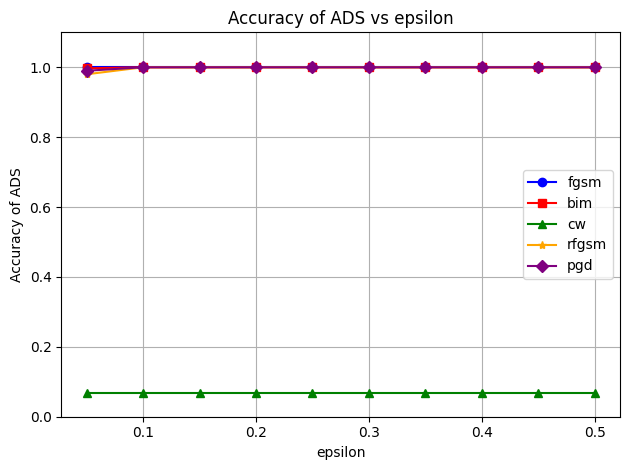

In [ ]:
import matplotlib.pyplot as plt

# Given ASR values for two sets
asr_values_set1 = [1,1, 1, 1, 1, 1, 1, 1, 1, 1]
asr_values_set2 = [1,1,1,1, 1,1, 1, 1, 1, 1]
asr_values_set3 = [0.102,0.109,0.109, 0.109, 0.109, 0.109, 0.109, 0.109, 0.109, 0.109]
asr_values_set4 = [1,1, 1, 1, 1, 1,1, 1,  1, 1]
asr_values_set5 = [1,1, 1, 1, 1, 1, 1, 1, 1, 1]

# Create a list of feature numbers starting from one
feature_numbers = [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]

# Plotting the graphs
plt.ylim(0, 1.1)
plt.plot(feature_numbers, asr_values_set1, marker='o', linestyle='-', color='b', label='fgsm')
plt.plot(feature_numbers, asr_values_set2, marker='s', linestyle='-', color='r', label='bim')
plt.plot(feature_numbers, asr_values_set3, marker='^', linestyle='-', color='g', label='cw')  # Different color for set3
plt.plot(feature_numbers, asr_values_set4, marker='*', linestyle='-', color='orange', label='rfgsm')  # Different color for set4
plt.plot(feature_numbers, asr_values_set5, marker='D', linestyle='-', color='purple', label='pgd')
# Adding legend
plt.legend()

plt.xlabel('epsilon')
plt.ylabel('Accuracy of ADS')
plt.title('Accuracy of ADS vs epsilon')
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/ADS_faultzone.pdf', format='pdf')
plt.show()
